In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
from tqdm import tqdm, trange
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import random
import gymnasium as gym
from gymnasium import spaces
from gym.utils import seeding
from scipy import signal
import scipy.io
import statistics

In [2]:
class virtual_wind_tunnel:
    def __init__(self, max_step, fan_number, speed_history_target, wind_tunnel_model):
        self.max_step = max_step
        self.fan_number = fan_number
        self.speed_history_target = speed_history_target
        self.wind_tunnel_model = wind_tunnel_model 
        self.state = np.zeros(self.fan_number*4) # speed_actual, speed_target, action_old, action_old_old 
        self.step_number = 0
        self.total_action = np.zeros(self.fan_number)
    
    def reset(self):
        self.state = np.zeros(self.fan_number*4)
        self.state[0:self.fan_number] = self.speed_history_target[0,:]
        self.state[self.fan_number:2*self.fan_number] = self.speed_history_target[1,:]
        self.step_number = 0
        self.total_action = np.zeros(self.fan_number)

        info = {}

        return self.state, info

    def step(self, action_integer):
        action_string = bin(action_integer)[2:] 
        action_string_add = action_string.zfill(8)
        action = [int(bit) if bit == '1' else -1 for bit in action_string_add]
        action = np.array(action) * 0.3
        terminated = False
        truncated = False
        speed_actual = self.state[0:self.fan_number]
        speed_target = self.state[self.fan_number:2*self.fan_number]
        action_old = self.state[2*self.fan_number:3*self.fan_number]
        action_old_old = self.state[3*self.fan_number:4*self.fan_number]

        for i in range(self.fan_number):
            if self.total_action[i] + action[i] < 0:
                action[i] = 0

        self.total_action = self.total_action + action

        speed_actual_new = speed_actual + np.matmul(self.wind_tunnel_model, action) + 0.3*np.matmul(self.wind_tunnel_model, action_old) + 0.1*np.matmul(self.wind_tunnel_model, action_old_old)
        reward = -np.sum(np.abs(speed_actual_new - speed_target))

        if self.step_number == self.max_step-1:
            terminated = True
            self.state = np.concatenate((speed_actual_new, speed_target, action, action_old))
        else:
            speed_target_new = self.speed_history_target[self.step_number+2,:]
            self.state = np.concatenate((speed_actual_new, speed_target_new, action, action_old))

        self.step_number = self.step_number + 1

        info = {}

        return self.state, reward, terminated, truncated, info 

In [3]:
class NN_DQN(nn.Module):

    def __init__(self, obs_space, act_space, hidden_layer_1, hidden_layer_2):

        super(NN_DQN, self).__init__()
        self.fc1 = nn.Linear(obs_space, hidden_layer_1)
        self.fc2 = nn.Linear(hidden_layer_1, hidden_layer_2)
        self.fc3 = nn.Linear(hidden_layer_2, act_space)
        self.relu = nn.ReLU()

    def forward(self, x):

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [4]:
class env_process:
    def __init__(self, env):
        self.env = env
    def action_select_random(self):
        action = np.random.randint(0, 256)
        return action
    
    def step(self,action):
        observation, reward, terminated, truncated, info = self.env.step(action)
        observation_tensor = torch.tensor(observation,dtype=torch.float32)
        return observation_tensor, reward, terminated, truncated, info
        
    def reset(self):
        observation, info = self.env.reset()
        observation_tensor = torch.tensor(observation,dtype=torch.float32)
        return observation_tensor, info

In [5]:

class train:
    
    def __init__(self, NN_DQN, NN_DQN_target, lr_nn):

        self.NN_DQN = NN_DQN
        self.running_loss = []
        self.loss_buffer=[]
        self.NN_DQN_target = NN_DQN_target
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.NN_DQN.parameters(), lr = lr_nn)

    def train(self, minibatch, gamma, train_type):

        
        i = 0

        if train_type == 0:

            for item in minibatch:

                buffer_obs_old = item[0]
                batch_action = item[1]
                buffer_reward = item[2]
                buffer_obs_new = item[3]
                terminated=item[4]
                self.optimizer.zero_grad()
                with torch.no_grad():
                    Q_value_target = self.NN_DQN_target(buffer_obs_new.cuda())
                Q_value_max, _ = torch.max(Q_value_target, dim=0)
                if not terminated:
                    target = buffer_reward + gamma * Q_value_max
                else:
                    target=torch.tensor(buffer_reward,dtype=torch.float32).cuda()
                Q_value = self.NN_DQN(buffer_obs_old.cuda())
                outputs = Q_value[batch_action]
                loss = self.criterion(outputs, target)
                loss.backward()
                self.optimizer.step()
                self.loss_buffer.append(loss.item())
                if i % 1000==0:
                    self.running_loss.append(statistics.mean(self.loss_buffer[:100]))
                i += 1

        #####################################################    
        else:
            
            for item in minibatch:

                buffer_obs_old = item[0]
                batch_action = item[1]
                buffer_reward = item[2]
                buffer_obs_new = item[3]
                terminated=item[4]
                self.optimizer.zero_grad()
                with torch.no_grad():
                    Q_value_target = self.NN_DQN_target(buffer_obs_new.cuda())
                _, new_action = torch.max(Q_value_target, dim=0)
                Q_value_NN = self.NN_DQN(buffer_obs_new.cuda())
                Q_value_NN_action = Q_value_NN[new_action]
                if not terminated:
                    target = buffer_reward + gamma * Q_value_NN_action
                else:
                    target=torch.tensor(buffer_reward,dtype=torch.float32).cuda()
                Q_value = self.NN_DQN(buffer_obs_old.cuda())
                outputs = Q_value[batch_action]
                loss = self.criterion(outputs, target)
                loss.backward()
                self.optimizer.step()
                self.loss_buffer.append(loss.item())
                if i % 1000==0:
                    self.running_loss.append(statistics.mean(self.loss_buffer[:100]))
                i += 1
        ########################################################################
        
        return self.NN_DQN,self.running_loss


In [6]:
class DQN:

    def __init__(self, env, obs_space, act_space, gamma = 0.9, buffer_size=512, batch_size = 64, hidden_layer_1 = 32, hidden_layer_2 = 32, train_episode = 500, env_type=0, train_type = 0, tao = 0.7):
        self.env_type = env_type
        self.train_type = train_type
        self.tao = tao
        self.env = env
        self.env_process = env_process(env)
        self.gamma = gamma
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.train_episode = train_episode
        self.NN_DQN = NN_DQN(obs_space, act_space, hidden_layer_1, hidden_layer_2).cuda()
        self.NN_DQN_target = NN_DQN(obs_space, act_space, hidden_layer_1, hidden_layer_2).cuda()
        self.reward_sum_table = []
        self.train_epsilon_table = []
        self.buffer_action = deque(maxlen = buffer_size)
        self.buffer_obs_old = deque(maxlen = buffer_size)
        self.buffer_obs_new = deque(maxlen = buffer_size)
        self.buffer_reward = deque(maxlen = buffer_size)
        self.terminal=deque(maxlen = buffer_size)
        self.loss_sum=[]
        self.eval_step=0 
    def eval(self):
        reward_sum_table=[]
        observation_sum=[]
        total_reward=0
        terminated, truncated = False, False
        for i in range(5):
            observation, info = self.env_process.reset()
            observation_sum.append(observation.numpy())
            while (not terminated) and (not truncated):
                state = observation
                Q_value = self.NN_DQN(observation.cuda())
                _, action_tensor = torch.max(Q_value, dim=0)
                action=action_tensor.item()
                observation_new, reward, terminated, truncated, info = self.env_process.step(action)
                observation_sum.append(observation_new.numpy())
#                 print(observation_sum)
                next_state = observation_new
                if self.env_type==1:
                    # reward = 100*((torch.sin(3*next_state[0]) * 0.0025 + 0.5 * next_state[1] * next_state[1]) - (torch.sin(3*state[0]) * 0.0025 + 0.5 * state[1] * state[1]))
                    reward=reward
                if self.env_type==2:
                    reward = reward
                else:
                    reward=reward
                if terminated or truncated:
                    observation, info = self.env_process.reset()
                total_reward = total_reward + reward
                observation = next_state
                self.eval_step= self.eval_step+1 
            reward_sum_table.append(total_reward)
        return reward_sum_table, observation_sum
    def DQN_train(self):
        
        epsilon = 1
        t = trange(self.train_episode)
        total_reward = 0
        decay_rate_epsilon = 10 ** (-3 / self.train_episode)
        total_step = 0
        
        for i in t:
            total_reward = 0
            observation, info = self.env_process.reset()
            test_step = 0
            terminated, truncated = False, False
            state = observation
            while (not terminated) and (not truncated):

                if np.random.random() < epsilon:
                    action = self.env_process.action_select_random() 
                else:
                    observation=observation.flatten()
                    Q_value = self.NN_DQN(observation.cuda())
                    _,  action_tensor = torch.max(Q_value, dim=0)
                    action=action_tensor.item()
                observation_new, reward, terminated, truncated, info = self.env_process.step(action)
                next_state = observation_new
                if self.env_type==1:
                    reward = 100*((torch.sin(3*next_state[0]) * 0.0025 + 0.5 * next_state[1] * next_state[1]) - (torch.sin(3*state[0]) * 0.0025 + 0.5 * state[1] * state[1]))
                if self.env_type==2:
                    reward = reward
                else:
                    reward=reward
                self.buffer_obs_old.append(observation)       
                self.buffer_action.append(action)
                self.buffer_reward.append(reward)
                self.buffer_obs_new.append(observation_new)
                self.terminal.append(terminated)
                if total_step > self.batch_size:
                    batch = zip(self.buffer_obs_old, self.buffer_action, self.buffer_reward, self.buffer_obs_new, self.terminal)
                    batch_list = list(batch)
                    minibatch = random.sample(batch_list, self.batch_size)
                    DQN_NN_train = train(self.NN_DQN, self.NN_DQN_target, 0.0003)
                    ##################################
                    self.NN_DQN,loss = DQN_NN_train.train(minibatch, self.gamma, self.train_type)
                    self.loss_sum.extend(loss)
                    ##################################
                
                ###########################################
                if test_step % 10 == 9:
                    if self.train_type == 0:    
                        self.NN_DQN_target.load_state_dict(self.NN_DQN.state_dict())
                    else:
                        self.tao=0.7
                        for target, source in zip(self.NN_DQN_target.parameters(), self.NN_DQN.parameters()):
                            target.data.copy_(target.data * (1.0 - self.tao) + source.data * self.tao)
                ###########################################

                if terminated or truncated:
                    observation, info = self.env_process.reset()
                total_reward = total_reward + reward
                observation = next_state
                test_step += 1
                total_step += 1
                
                t.set_postfix(epsilon = epsilon, reward = reward, timesteps = test_step)

            self.reward_sum_table.append(total_reward)
            self.train_epsilon_table.append(epsilon)
            epsilon = epsilon * decay_rate_epsilon

        torch.save(self.NN_DQN_target.state_dict(), 'assignment2_NN_DQN_target'+str(self.env_type)+str(self.train_type)+'.pth')
        torch.save(self.NN_DQN.state_dict(), 'assignment2_NN_DQN'+str(self.env_type)+str(self.train_type)+'.pth')
        return self.reward_sum_table, self.train_epsilon_table, self.loss_sum


100%|██████████| 1500/1500 [1:45:38<00:00,  4.23s/it, epsilon=0.001, reward=-2.73, timesteps=200]  


Text(0, 0.5, 'Epsilon')

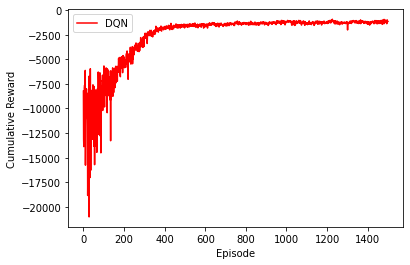

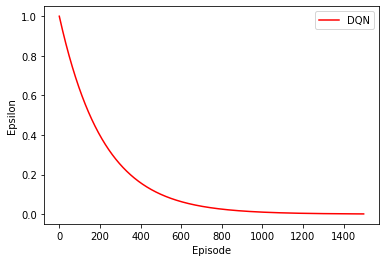

In [7]:
Target_turbulence = scipy.io.loadmat('Target_turb.mat')
speed_target=Target_turbulence['u2_all']
speed_target = np.transpose(speed_target)

wind_tunnel_model = np.array([ [0.8, 0.15,  0.1,  0., 0., 0.,  0.,  0.],
       [0.15, 0.9,  0.15,  0.1, 0., 0.,  0.,  0.],
       [0.1, 0.15,  0.9,  0.15, 0.1, 0.,  0.,  0.],
       [0., 0.1,  0.15,  0.9, 0.15, 0.1,  0.,  0.],
       [0., 0.,  0.1,  0.15, 0.9, 0.15,  0.1,  0.],
       [0., 0.,  0.,  0.1, 0.15, 0.9,  0.15,  0.1],
       [0., 0.,  0.,  0., 0.1, 0.15,  0.9,  0.15],
       [0., 0.,  0.,  0., -0., 0.1,  0.15,  0.8]])

# print(speed_target.shape[1])

env = virtual_wind_tunnel(max_step=200, fan_number=8, speed_history_target=speed_target, wind_tunnel_model=wind_tunnel_model)
agent_DQN = DQN(env, obs_space = 32, act_space = 256,  train_episode = 1500, buffer_size=128, batch_size = 16, \
                     hidden_layer_1 = 1024, hidden_layer_2 = 512,env_type=0, train_type = 0)
reward_DQN, epsilon_DQN, _ = agent_DQN.DQN_train()

plt.figure(1)    
plt.plot(range(len(reward_DQN)), reward_DQN, label = 'DQN', color = 'r')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')

plt.figure(2)
plt.plot(epsilon_DQN, label = 'DQN', color = 'r')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Epsilon')


(205, 32)


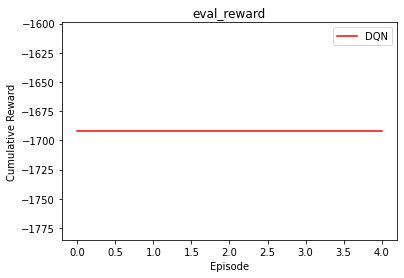

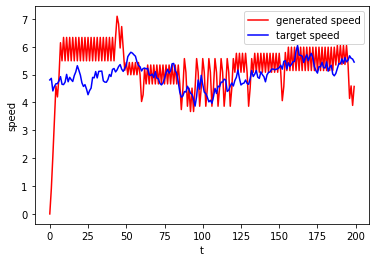

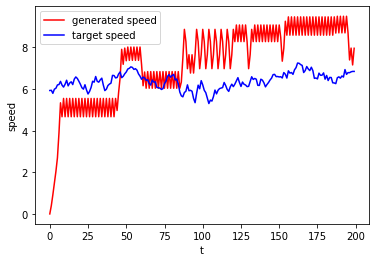

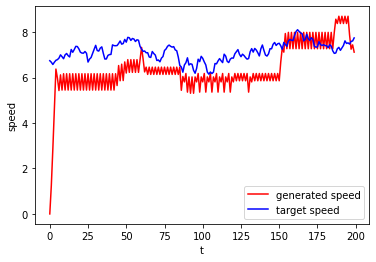

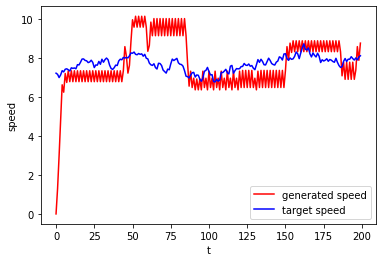

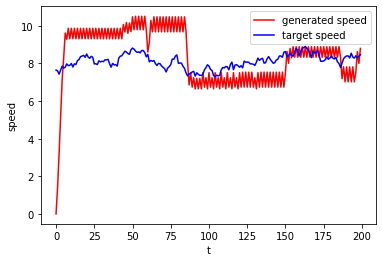

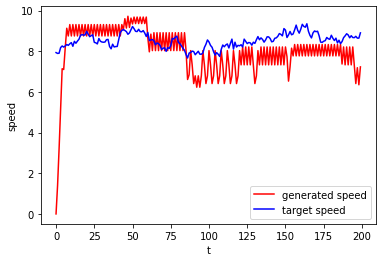

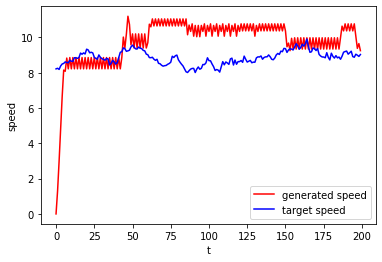

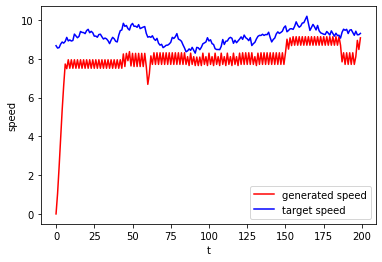

In [8]:
eval_reward_DQN, eval_observation_DQN=agent_DQN.eval()

plt.figure(3)    
plt.plot(eval_reward_DQN, label = 'DQN', color = 'r')
plt.legend()
plt.title('eval_reward')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')

eval_observation_DQN_np=np.array(eval_observation_DQN)
print(eval_observation_DQN_np.shape)

for i in range(8):
    plt.figure(4+i)    
    plt.plot(eval_observation_DQN_np[0:200,i], label = 'generated speed', color = 'r')
    plt.plot(eval_observation_DQN_np[0:200,i+8], label = 'target speed', color = 'b')
    plt.legend()
    plt.xlabel('t')
    plt.ylabel('speed')

Text(0, 0.5, 'height')

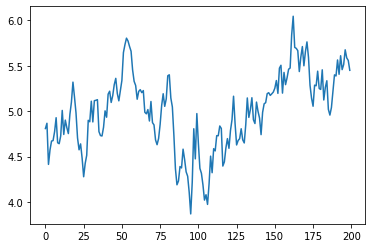

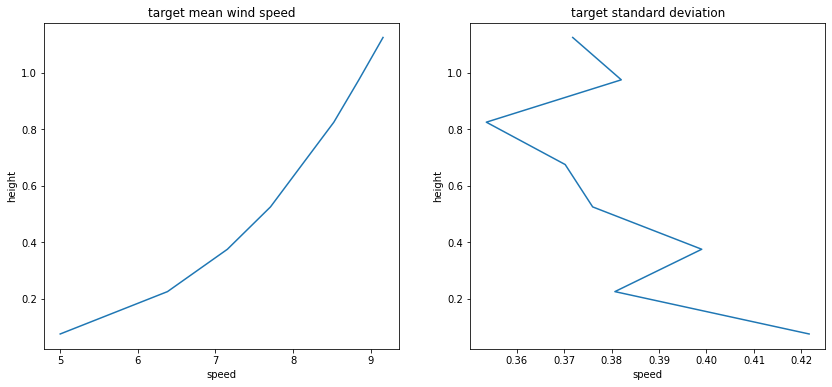

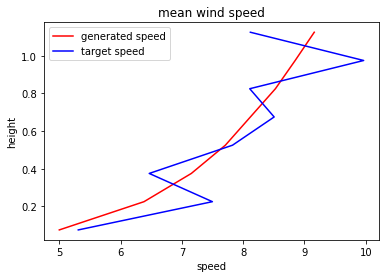

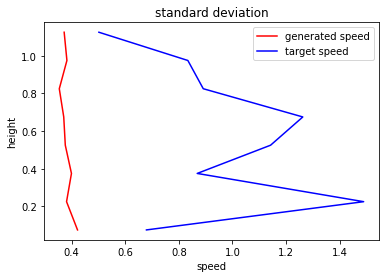

In [9]:
plt.figure(20)    
plt.plot(speed_target[0:200,0])

speed_target_means = np.mean(eval_observation_DQN_np[0:200,8:16], axis=0)
speed_generated_means = np.mean(eval_observation_DQN_np[10:200,0:8], axis=0)
speed_target_std = np.std(eval_observation_DQN_np[0:200,8:16], axis=0)
speed_generated_std = np.std(eval_observation_DQN_np[10:200,0:8], axis=0)
h = np.linspace(0.075, 1.125, 8)


fig, axs = plt.subplots(1, 2, figsize=(14, 6))   
axs[0].plot(speed_target_means,h)
axs[0].set_title('target mean wind speed')
axs[0].set_xlabel('speed')
axs[0].set_ylabel('height')
axs[1].plot(speed_target_std,h)
axs[1].set_title('target standard deviation')
axs[1].set_xlabel('speed')
axs[1].set_ylabel('height')


plt.figure(22)    
plt.plot(speed_target_means,h, label = 'generated speed', color = 'r')
plt.plot(speed_generated_means,h, label = 'target speed', color = 'b')
plt.legend()
plt.title('mean wind speed')
plt.xlabel('speed')
plt.ylabel('height')


plt.figure(24)    
plt.plot(speed_target_std,h, label = 'generated speed', color = 'r')
plt.plot(speed_generated_std,h, label = 'target speed', color = 'b')
plt.legend()
plt.title('standard deviation')
plt.xlabel('speed')
plt.ylabel('height')

100%|██████████| 1500/1500 [2:58:11<00:00,  7.13s/it, epsilon=0.001, reward=-1.79, timesteps=200]    


Text(0, 0.5, 'Epsilon')

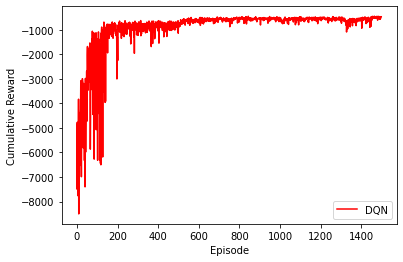

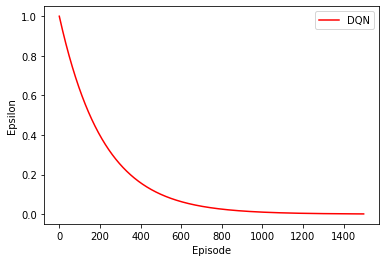

In [7]:
Target_turbulence = scipy.io.loadmat('Target_turb.mat')
speed_target=Target_turbulence['u2_all']
speed_target = np.transpose(speed_target)

wind_tunnel_model = np.array([ [0.8, 0.15,  0.1,  0., 0., 0.,  0.,  0.],
       [0.15, 0.9,  0.15,  0.1, 0., 0.,  0.,  0.],
       [0.1, 0.15,  0.9,  0.15, 0.1, 0.,  0.,  0.],
       [0., 0.1,  0.15,  0.9, 0.15, 0.1,  0.,  0.],
       [0., 0.,  0.1,  0.15, 0.9, 0.15,  0.1,  0.],
       [0., 0.,  0.,  0.1, 0.15, 0.9,  0.15,  0.1],
       [0., 0.,  0.,  0., 0.1, 0.15,  0.9,  0.15],
       [0., 0.,  0.,  0., -0., 0.1,  0.15,  0.8]])

# print(speed_target.shape[1])

env = virtual_wind_tunnel(max_step=200, fan_number=8, speed_history_target=speed_target, wind_tunnel_model=wind_tunnel_model)
agent_DQN = DQN(env, obs_space = 32, act_space = 256,  train_episode = 1500, buffer_size=256, batch_size = 16, \
                     hidden_layer_1 = 1024, hidden_layer_2 = 512,env_type=0, train_type = 0)
reward_DQN, epsilon_DQN, _ = agent_DQN.DQN_train()

plt.figure(1)    
plt.plot(range(len(reward_DQN)), reward_DQN, label = 'DQN', color = 'r')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')

plt.figure(2)
plt.plot(epsilon_DQN, label = 'DQN', color = 'r')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Epsilon')

(205, 32)


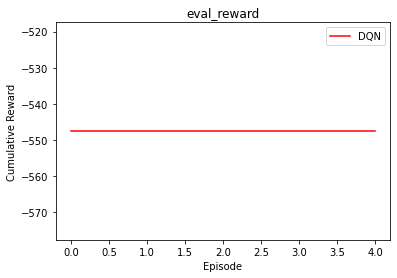

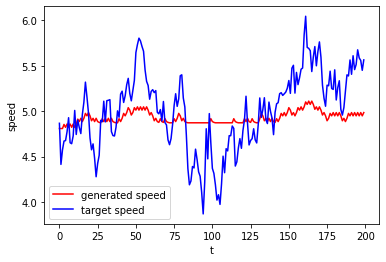

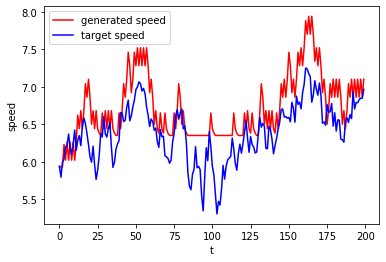

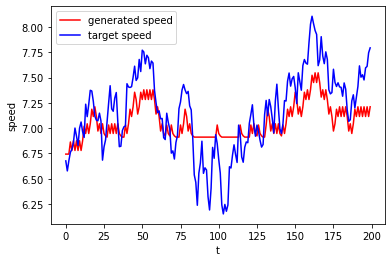

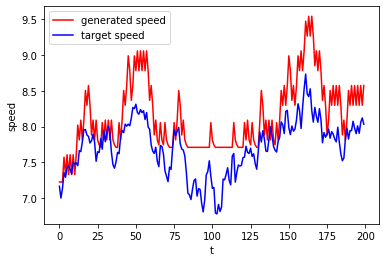

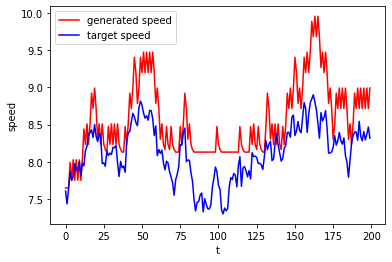

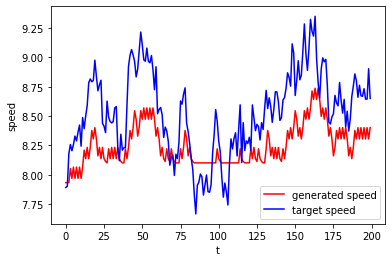

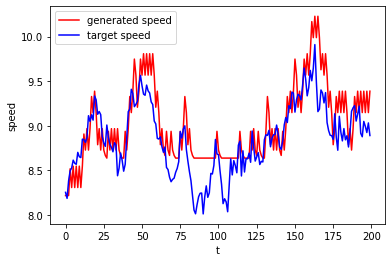

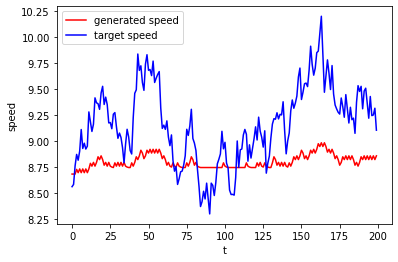

In [8]:
eval_reward_DQN, eval_observation_DQN=agent_DQN.eval()

plt.figure(3)    
plt.plot(eval_reward_DQN, label = 'DQN', color = 'r')
plt.legend()
plt.title('eval_reward')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')

eval_observation_DQN_np=np.array(eval_observation_DQN)
print(eval_observation_DQN_np.shape)

for i in range(8):
    plt.figure(4+i)    
    plt.plot(eval_observation_DQN_np[0:200,i], label = 'generated speed', color = 'r')
    plt.plot(eval_observation_DQN_np[0:200,i+8], label = 'target speed', color = 'b')
    plt.legend()
    plt.xlabel('t')
    plt.ylabel('speed')

Text(0, 0.5, 'height')

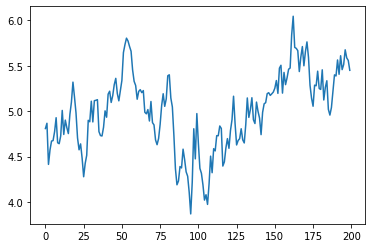

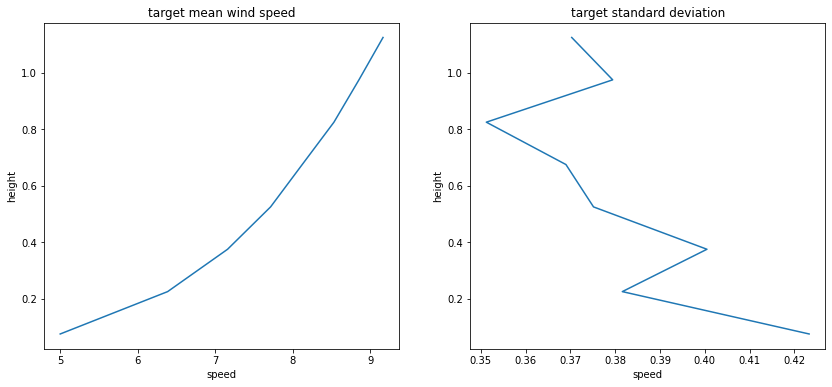

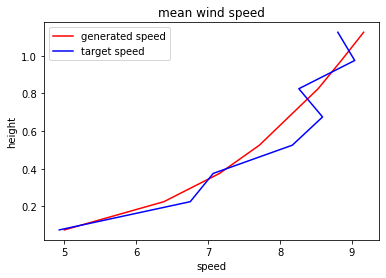

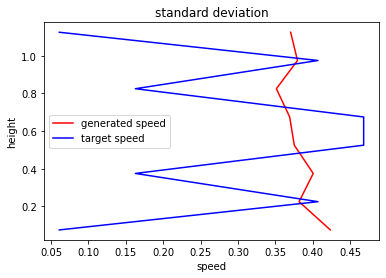

In [9]:
plt.figure(20)    
plt.plot(speed_target[0:200,0])

speed_target_means = np.mean(eval_observation_DQN_np[0:200,8:16], axis=0)
speed_generated_means = np.mean(eval_observation_DQN_np[10:200,0:8], axis=0)
speed_target_std = np.std(eval_observation_DQN_np[0:200,8:16], axis=0)
speed_generated_std = np.std(eval_observation_DQN_np[10:200,0:8], axis=0)
h = np.linspace(0.075, 1.125, 8)


fig, axs = plt.subplots(1, 2, figsize=(14, 6))   
axs[0].plot(speed_target_means,h)
axs[0].set_title('target mean wind speed')
axs[0].set_xlabel('speed')
axs[0].set_ylabel('height')
axs[1].plot(speed_target_std,h)
axs[1].set_title('target standard deviation')
axs[1].set_xlabel('speed')
axs[1].set_ylabel('height')


plt.figure(22)    
plt.plot(speed_target_means,h, label = 'generated speed', color = 'r')
plt.plot(speed_generated_means,h, label = 'target speed', color = 'b')
plt.legend()
plt.title('mean wind speed')
plt.xlabel('speed')
plt.ylabel('height')


plt.figure(24)    
plt.plot(speed_target_std,h, label = 'generated speed', color = 'r')
plt.plot(speed_generated_std,h, label = 'target speed', color = 'b')
plt.legend()
plt.title('standard deviation')
plt.xlabel('speed')
plt.ylabel('height')